## Audio Data Analysis
#### Shuyi Li,  2019-04-02

### Table of content: 
#### 0. Quick remarks about the Question Set
#### 1. Toward Kaggle style dataset
#### 2. Data Analysis
#### 3. Machine Learning
#### 4. Feature Importance and Model Explanation



### 0. Quick remarks about the Question Set:
**1. How did you go about extracting features from the raw data?**

Fourier transform to frequency domain, amplitude normalization, rolling average smoothing and then extract statistical features suggested in the assignment. Also data was divided into two frequency ranges separated by 180 Hz. The peak positions (peak_lo, peak_high) in both ranges were extracted as well as the peak height ratio (p_ratio, p_ratio_submin). 

I understand that simple statistical features are very crude and doesn't capture the textural quality of the voices. In hindsight, it would have been better to also extract "adult or not" and language in addition to gender info from the readme file in each folder.  

If given longer time and better computer I would make spectrograms for each individual and run a CNN for the classification.

**2. Which features do you believe contain relevant information?**   
By observing the spectrum in freuqency domain, it was easy to notice that Males had low frequency peak occasionally in addition to a high frequency peak as well. This structure also would cause larger interquantile range and standard deviation. Therefore I believed that peak_lo and peak_high, and p_ratio or p_ratio_submin should be important.  

**3. How did you decide which features matter most?  **

Three different importance measures were used, i.e., SHAP, Random Forest, and PCA. SHAP and Random Forest importance aggree somewhat. Over all the most important features are: peak_lo (low fre peak position), kurtosis, q1 (1st quantile position), q3 (3rd quantile position), peak_hi (high frequency range peak position), p_ratio_submin (peak ratio corrected by background).

** 4. Do any features contain similar information content? **  

From pairploting, it was found that
* mean, medium, q1, q3, log(pratio), log(pratio_sub) are positively correlatd.
* Skewness is negatively correlated with the above quantities.
* interq and std are positively correlated
* kurtosis and interq^2 are negatively correlated.
* In histogram distribution plot, the features best separate M and F classes are: std, q1, interq, log(kurt), peak_lo.

** 5. Are there any insights about the features that you didn't expect? If so, what are they? **  

In fact it is the Kurtosis. Observing the pairplots for data with log transformed kurtosis, it is clear that male has lower kurtosis than females. 

** 6. Are there any other (potential) issues with the features you've chosen? If so, what are they? **  

peak_lo and peak_high is very crude for capturing the Male vs. Female spectual profile. A CNN-derived feature should work better. However, when solving this problem, my computer became very slow due to some package installation, so I couldn't get enough time to build a CNN model. virtual environment way of working should be enforced also in my home computer!

** 7. Which goodness of fit metrics have you chosen, and what do they tell you about the model(s) performance? **  

The dataset is imbalanced with M:F = 13, if classify everyone to be male the accuracy would be 92.8%. Therefore, F1 score was chosen to maximize to for the model performance. F1 score is the harmonic mean between precision and recall defined as follows:

* precision: true predicted positive share in predicted positive. (The ability to exclude non-positive class.)

* recall: true predicted positive share in actual positive class.(The ability to reach positive class.)


** 8. Which model performs best?**

Random Forest in this case. It is very robust and to data with different type of distributions. Also the bagging within reduces variance that plagues decision trees. In addition, random selection of features helps reducing bias introduced by some dominating features.

** 9. How would you decide between using a more sophisticated model versus a less complicated one? ** 

Depend on the explanability, scalability, production-compatibility and the business case. If increasing a few % accuracy doesn't bring real insight or benefit and waste time and resources unnecessarily, then a simpler and faster model should be prefered.

** 10. What kind of benefits do you think your model(s) could have as part of an enterprise application or service? **

Speech gender determination problem itself may not have much un-creepy practical usecase. However, machine learning models in general will give extra edge to many decision making processes. In gaming industry, it could help identify valuable players for bonus rewards, which used to be mostly decided by gut-feeling in the past.

### 1. Towards Kaggle style dataset
load basic packages

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os, sys
import pandas as pd
CURR_PATH = os.path.join(os.getcwd(), os.pardir)
sys.path.append(CURR_PATH)

load code module make_data_stats.py and paths

In [3]:
import make_data_stats as mkd
DATA_RAW, PROCESSED, CURR_PATH = mkd.DATA_RAW, mkd.PROCESSED, mkd.CURR_PATH


#### Workflow:
** Automated downloading and file extraction >> Gender Info extraction >> Audio data processing >> Noise Reduction >> data observation and visualization>> Build stats features **  
One can achieve all the steps in the workflow by running make_data_stats.py

```python
python make_data_stats.py 1
```
#### Project structure
```
project_root:
    -data:
        -raw:
          -raw data, 6247 audio files        
        -processed:
          -extracted data like df_stats_summary.csv etc
    -src:
        codes and notebooks
```

#### Workflow Breakdown
1. **Automated downloading and file extraction.**   
Webscraper was built to automate downloading the compressed files and their extraction. The webscrapper function is located in module mkd. 

```python
mkd.download_extract(DATA_RAW)
```
The extracted folders are stored in DATA_RAW. Which is project_root/data/raw
2. **Gender information extraction.**   
Gender information was found to be hidden in folder/etc/README file, and was extracted with function:
```python
mkd.df_init()
```

In [16]:
df_init = pd.read_csv(PROCESSED +os.sep + 'df_init.csv', sep = ';')
df_init.head(5)

id gender
0    1028-20100710-hne      M
1  1337ad-20170321-ajg      F
2  1337ad-20170321-tkg      F
3  1337ad-20170321-ynk      F
4  1snoke-20120412-hge      M

The 'id' column is the name of the folder from each person.

3. **Audio data processing.**   
For the 10 tracks in folder/wav/ folder, fast fourier transform was done on each of them to convert the data from time space into frequency space (freq, amp) with amplitude normalized. Then the (freq, amp) data from 10 tracks were concatenated in one and sorted by freq and then the amp was normalized again. 
4. **Noice reduction**   
The numerical data extracted from the wav files from above steps was very noisy. In order to reduce the noise and for better visualization of the data rolling average was taken for smoothing purposes. Rolling average also tones down narrow high intensity noises from the backgrounds.   
5. **Data observation visualization**
    * 6247 individuals with 5723 males 459 females and 63. Not all people had audio files according to the preset rules, automated data extraction and discarding the unsuccessful ones, there are 5635 males and 432 females in the final sample. 
    * First 10 data sets from the first 10 individuals was visualized. Frequencies higher than 300 Hz differ very little between male and female. Frequencies below 70 Hz are not feature-rich either and are subjected to background noise (Mains hum of 50, 60 Hz etc). For this reason only the spectral range between 70 and 300 Hz are kept for analysis. The first 10 samples are visualized in the following, which shows that males have a low frequency peak (freq <=180Hz) sometimes in addition to high frequency peaks (freq >= 180 Hz) and women typically has peaks in higher frequency range (freq >= 180 Hz).

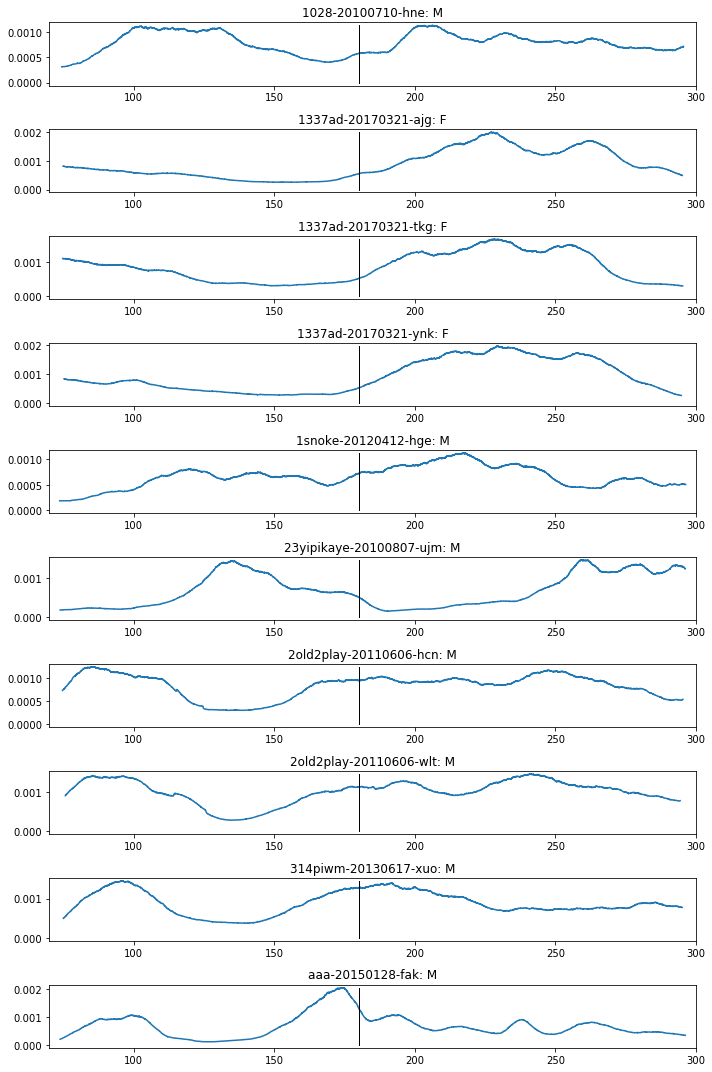

In [9]:
# This only works after all the files are downloaded and extracted
mkd.fig_10samples() # the vertical line is 180 Hz

6. **Data feature building **  

Due to the fact that male and female voice has different frequency distributions, the statistical features suggested in the assignments are very likely useful. 

In addition, peak position of low frequency range (freq <= 180 Hz) and high frequency range (freq >= 180 Hz) were obtained and the ratio between the peak hight was obtained too, and the same ratio corrected by substracting the lowest level of the data is also included. The compelete sets of feature names and the corresponding meanings are as follows: 
* mean: mean (Hz)
* median: median (Hz)
* std: standard deviation (Hz)
* q1: 25% percentile (Hz)
* q3: 70% percentile (Hz)
* inter_q: frequency range in between 25% and 75% percentile
* skewness: skewness
* kurtosis: kurtosis
* peak_lo: peak position (Hz) in the low frequency range (freq <=180)
* peak_hi: peak position (Hz) in the high frequency range (freq >= 180)
* pratio: peak_hi/peak_lo
* pratio_submin: (peak_hi-min(amp))/(peak_lo-min(amp))

There are in total 12 features.

The following code acheiveds steps 3 - 6 row by row in df_init:
```python
best_grid_cv# dirname is information contained in df_init.id
```


The following code acheiveds steps 3 - 6 for all rows in df_init:
```python
mkd.get_dfstas(df, DATA_RAW, PROCESSED, 0) # dirname is information contained in df_init.id
```

Then the following trys to explore the opportunity of multiprocessing but the time performance improvement is none due to the fact that the essential bottleneck is not the CPU but memory.

```python
make_data_stats(multiproc = False)
```
The resulting dataset looks like this:

In [17]:
df = pd.read_csv(PROCESSED + os.sep  +'stats_summary.csv')
df.head(5)

id gender        mean      median        std  \
0   anonymous-20130702-vny      M  189.681363  188.699032  59.207473   
1   anonymous-20090711-zoe      M  178.055361  184.296296  62.923844   
2          mk-20120531-ctv      M  225.466142  235.000000  43.940276   
3  ductapeguy-20070619-com      M  200.772529  195.800687  50.433012   
4         zlp-20100110-hpf      M  162.673819  161.674419  62.180168   

           q1          q3     inter_q  skewness  kurtosis     peak_lo  \
0  142.428553  242.061492   99.632939 -0.043272  1.827318  163.742920   
1  116.413793  235.142857  118.729064  0.099687  1.508636  109.925926   
2  205.405405  255.000000   49.594595 -0.983638  3.576806  115.243243   
3  164.271368  239.018318   74.746950  0.100563  2.266520  179.627031   
4  101.581395  207.058824  105.477428  0.334268  1.995216   87.441860   

      peak_hi    pratio  pratio_submin  
0  237.172178  1.018657       1.021873  
1  226.571429  0.562033       0.523210  
2  238.204082  6.937837       7.169155  
3  186.883882  1.035407       1.036057  
4  180.000000  0.560373       0.454273

### 2. Data analysis
load mlproc module

In [1]:
import mlproc as ml

### Pairplot
#### No transformation

The pairplot was done with or with out transformation 

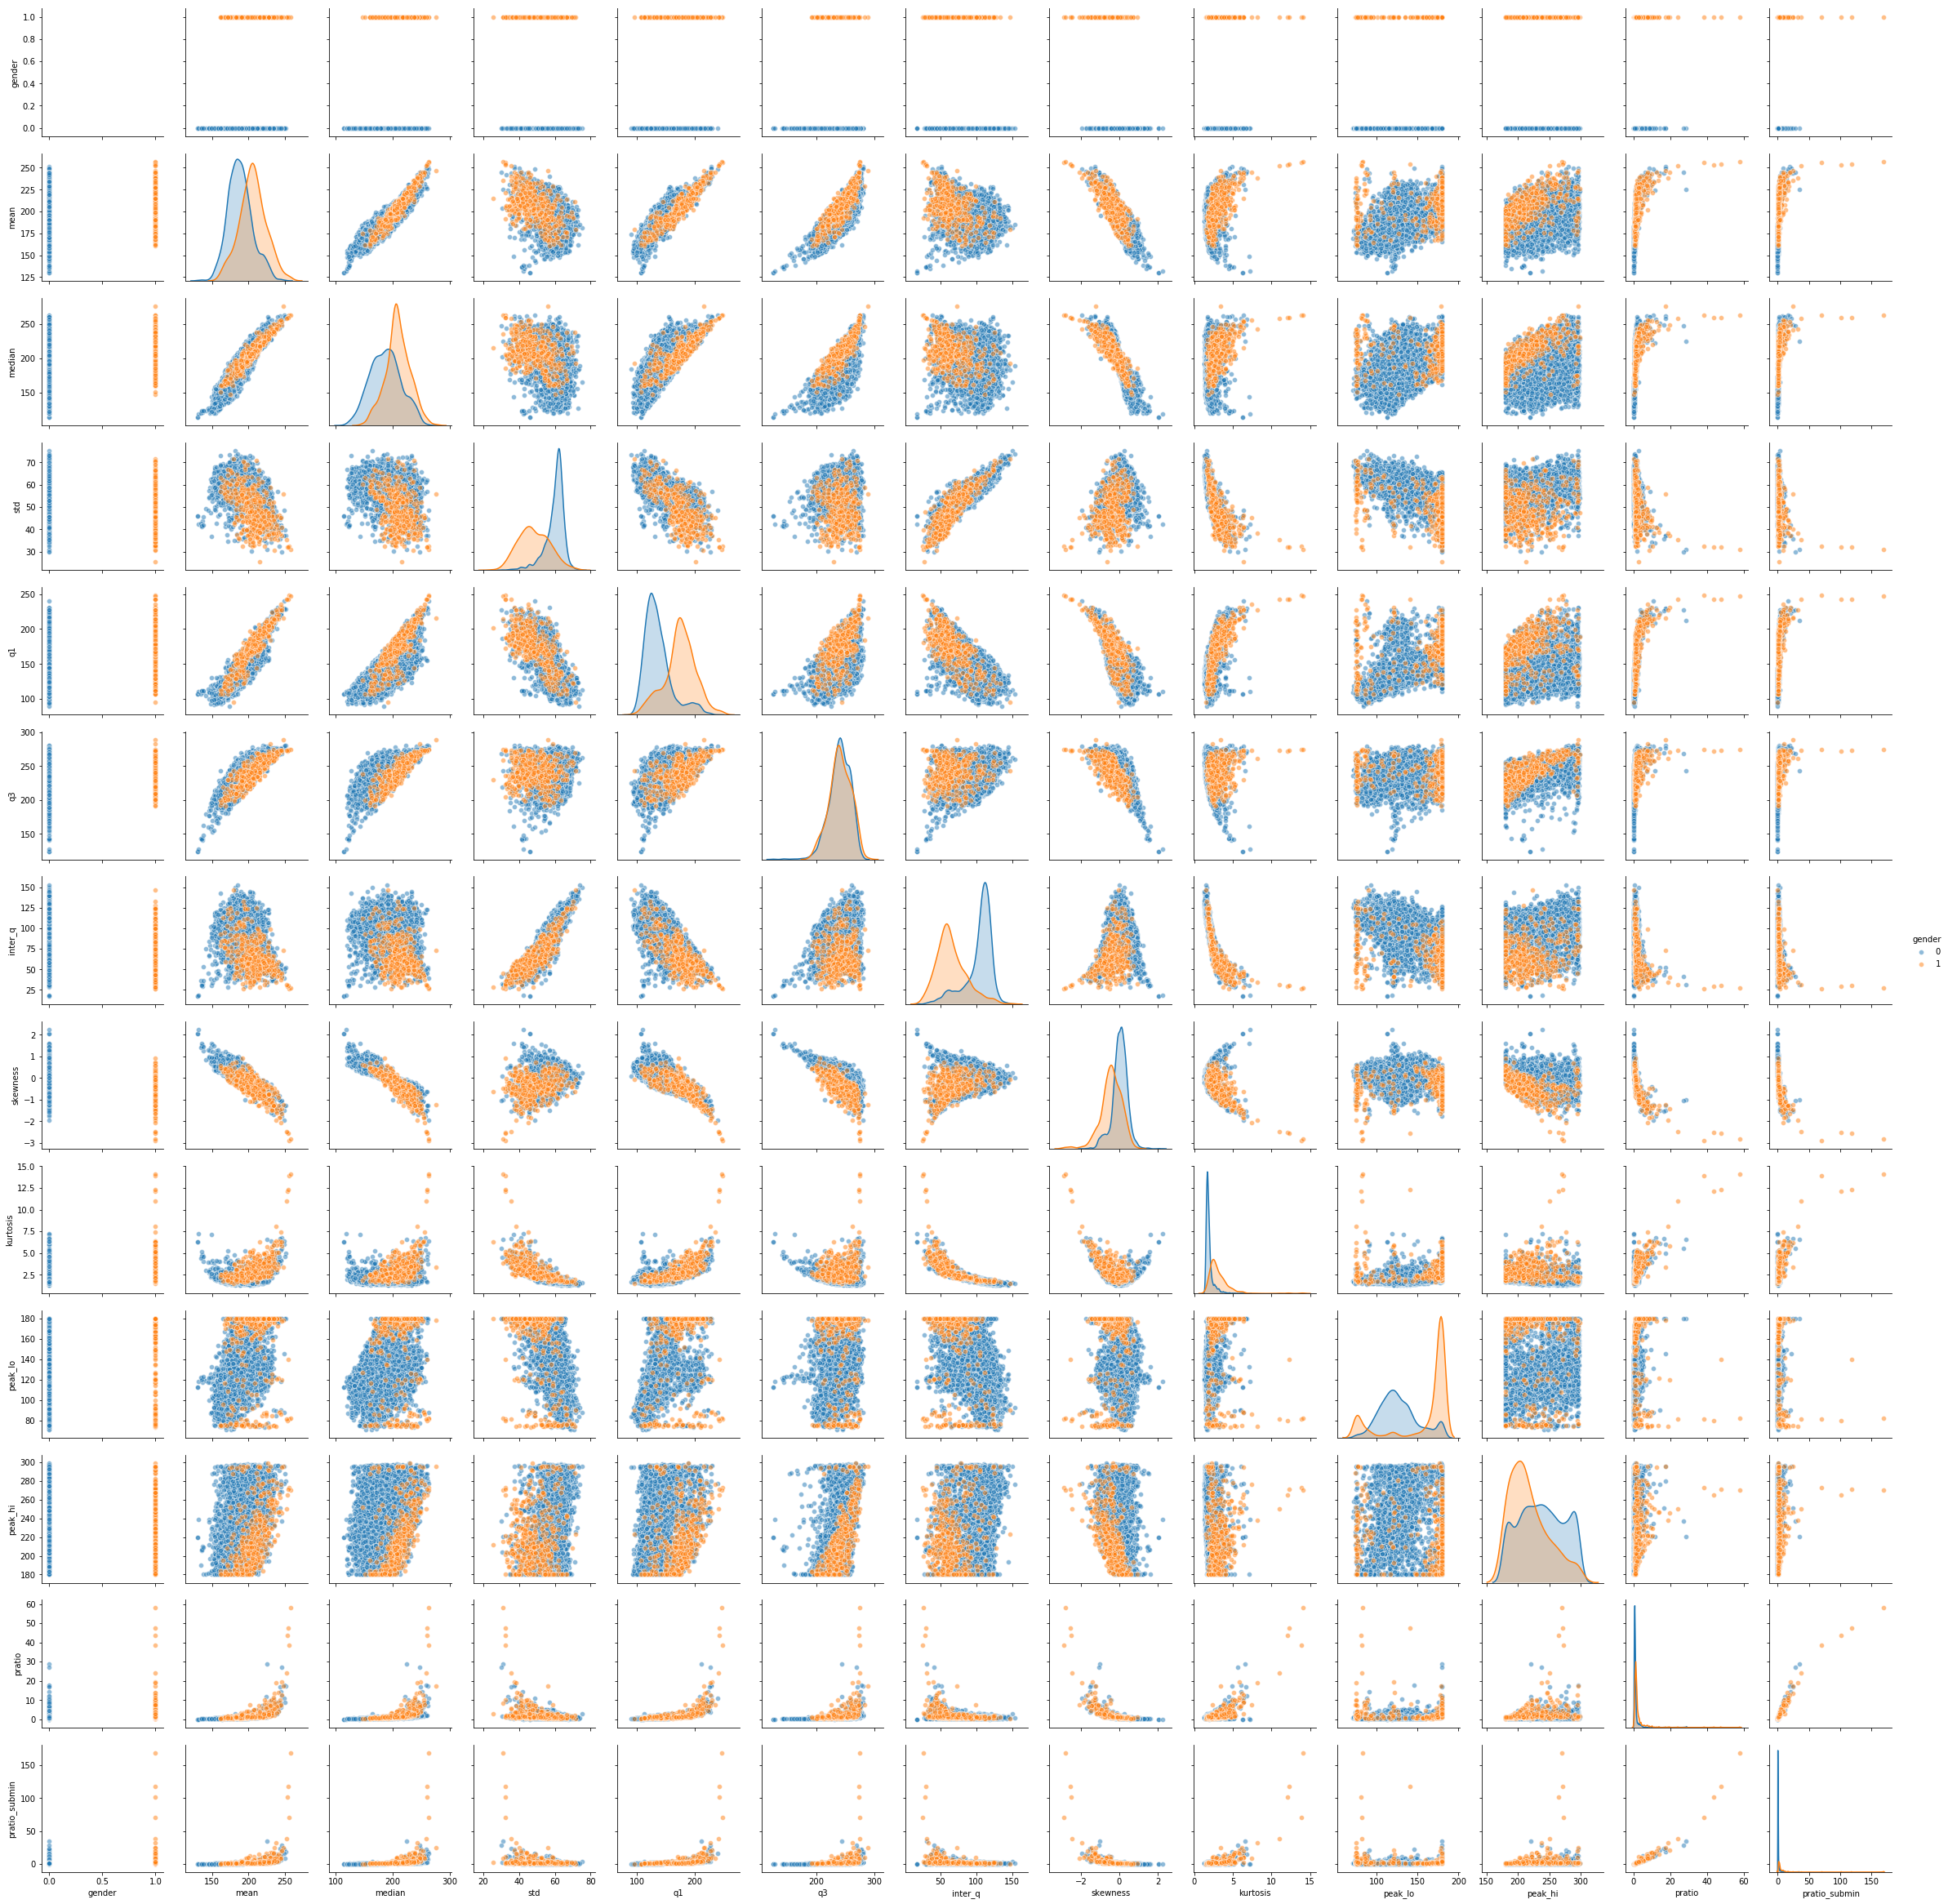

In [6]:
df, data, target = ml.preprocess() # raw data without any transformation
ml.sb.pairplot(df[df.columns[~df.columns.isin(['id'])]], hue = 'gender', kind='scatter', plot_kws={'alpha': 0.5})

#### Transformed data: log of pratio, pratio_submin, kurtosis, and taking squares of inter_q, and std
After the transformation many correlation between features and be discovered.

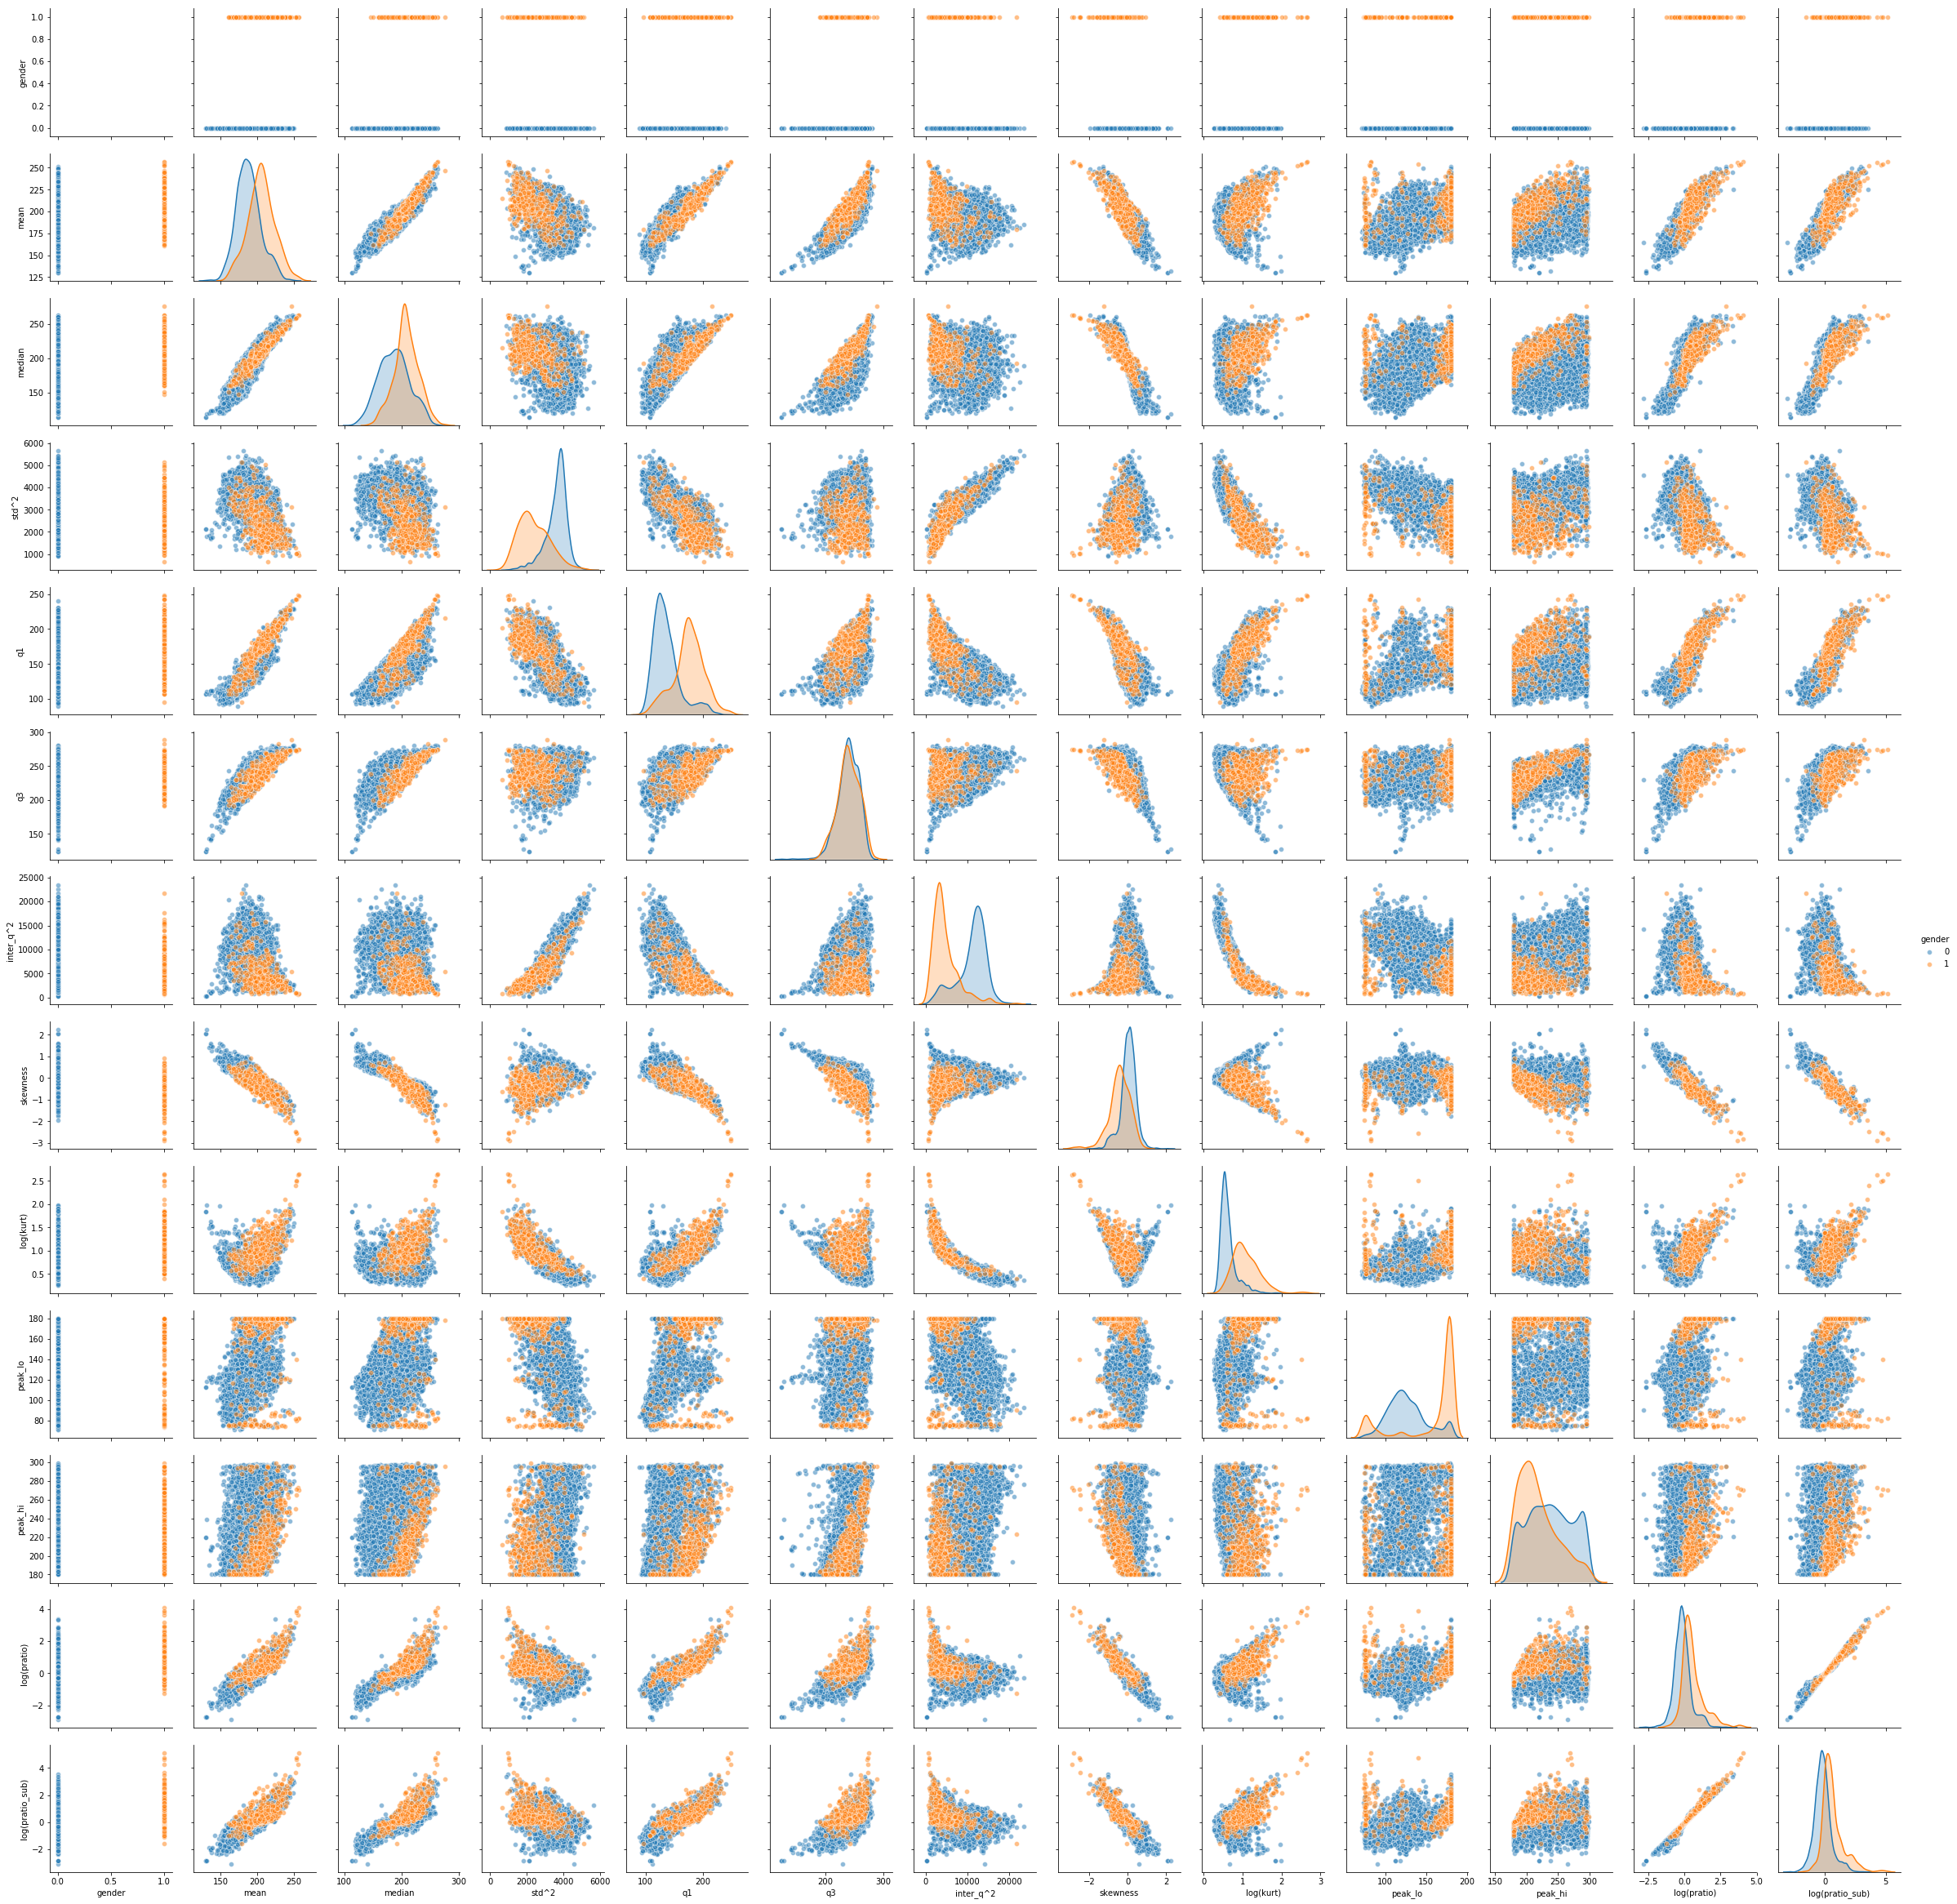

In [29]:
df, data, target = ml.preprocess(transf=True)
ml.sb.pairplot(df[df.columns[~df.columns.isin(['id'])]], hue = 'gender', kind='scatter', plot_kws={'alpha': 0.5})

#### Insights from pairplot: 
* It can be seen clearly that features mean, medium, q1, q3, log(pratio), log(pratio_sub) are positively correlatd.
* Skewness is negatively correlated with the above quantities. 
* interq and std are positively correlated
* kurtosis and interq^2 are negatively correlated.
* In histogram distribution plot, the features best separate M and F classes are: std, q1, interq, log(kurt), peak_lo.

### 3. Machine Learning
Data was split into train (90%) and test (10%) and stratified according to the distributin of y. The reason to keep a lot of data in the training set is to train a better model. The training set was split into 80% and 20% for a 6 fold cross validation.

8 machine learning algorithm was tried:
* Decision trees
* Random Forest
* Bagging
* Xgboost
* Gradient boosted trees
* KNN
* Support vector machines


The pipeline was in 3 steps 
1. scaler: StandardScaler() or RobustScaler(quantile_range=(2.5, 97.5))
2. with linear pca transformation or not.
3. Different classifiers with or without class weight balancing.

The initial model training was done by:
```python
df, data, target = ml.preprocess()
ml.trial_dataparams(data, target)
```

#### Initial Model comparison

In [21]:
cls_init = pd.read_csv(PROCESSED + os.sep + 'trial_dataparams_.csv', sep = ';')
cls_init['Model Name'].unique()
cls_init.head(5)
print('Pipeline')
cls_init.iloc[0]['Pipeline']

array(['RandomForestClassifier', 'BaggingClassifier', 'XGBClassifier',
       'KNeighborsClassifier', 'GradientBoostingClassifier', 'SVC',
       'DecisionTreeClassifier', 'LogisticRegressionCV'], dtype=object)

Model Name                                         Parameters  \
0  RandomForestClassifier  {'bootstrap': True, 'class_weight': None, 'cri...   
1       BaggingClassifier  {'base_estimator': None, 'bootstrap': True, 'b...   
2  RandomForestClassifier  {'bootstrap': True, 'class_weight': None, 'cri...   
3  RandomForestClassifier  {'bootstrap': True, 'class_weight': None, 'cri...   
4           XGBClassifier  {'base_score': 0.5, 'booster': 'gbtree', 'cols...   

  class_weight                                           Pipeline      Time  \
0          NaN  [('scaler', StandardScaler(copy=True, with_mea...  0.884165   
1         None  [('scaler', StandardScaler(copy=True, with_mea...  3.450956   
2          NaN  [('scaler', StandardScaler(copy=True, with_mea...  0.717454   
3          NaN  [('scaler', RobustScaler(copy=True, quantile_r...  0.681927   
4            1  [('scaler', StandardScaler(copy=True, with_mea...  0.299414   

   Train Accuracy Mean  Train F1 Mean  CV F1 Mean  CV F1 Std  \
0             0.999954       0.999678    0.685521   0.043112   
1             0.999954       0.999678    0.682646   0.037193   
2             0.999954       0.999678    0.669439   0.034823   
3             0.999954       0.999678    0.669439   0.034823   
4             0.975549       0.811866    0.667747   0.041240   

   CV Precision Mean  CV Recall Mean  CV Accuracy Mean  
0           0.794760        0.604229          0.960625  
1           0.780992        0.609391          0.959892  
2           0.772194        0.594073          0.958427  
3           0.772194        0.594073          0.958427  
4           0.765660        0.594006          0.958061

Pipeline


"[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,\r\n  svd_solver='auto', tol=0.0, whiten=False))]"


The best performing model from this initial model was Random Forest without class weight balancing. The data log transform and square transform didn't change the best model or the level of performance of the best model. PCA and choice of scaler also didn't matter very much either. So data with no transformation was used for fine tuning the Random Forest in a pipeline consists of StandardScaler and RandomForestClassifier only.

#### Grid search CV for Random Forest

Grid search with an objective to find maximum F1 score was done by:
```python
ml.randomforest_grids(data, target)
```
The hierachy was to find the best class_weight (found to be {0: 1, 1: 2} ) and n_estimators (100 performs just as well as 200) first. Then the grid search for max_depth, max_features, and min_samples_leaf was performed.
#### Best Model performance and parameters
F1 score of the CV set improved from 0.686 to 0.702. Accuracy had a very slight trade off which droped from 0.960 to 0.958.

In [20]:
rfc_grid = pd.read_csv(PROCESSED + os.sep + 'rfc_grid.csv', sep = ';')
#rfc_grid.columns
best_grid_cv = rfc_grid.sort_values(by = 'mean_test_F1_score', ascending = False)[['params','mean_test_F1_score','mean_test_Accuracy' ]].head(1)
best_grid_cv
print(best_grid_cv.params.values)

params  mean_test_F1_score  \
135  {'rfc__class_weight': {0: 1, 1: 2}, 'rfc__crit...            0.702724   

     mean_test_Accuracy  
135            0.958059

[ "{'rfc__class_weight': {0: 1, 1: 2}, 'rfc__criterion': 'gini', 'rfc__max_depth': 20, 'rfc__max_features': 5, 'rfc__min_samples_leaf': 10, 'rfc__n_estimators': 100, 'rfc__n_jobs': -1, 'rfc__random_state': 42, 'rfc__verbose': 1, 'rfc__warm_start': False}"]


#### Best model evalucation with test set
The test set F1 score is 0.62. 

In [53]:
df_clrepo = pd.read_csv(PROCESSED + os.sep + 'classification_report.csv', sep = ';')
df_clrepo

Unnamed: 0           0          1   micro avg   macro avg  weighted avg
0   f1-score    0.969751   0.622222    0.943987    0.795987      0.945132
1  precision    0.973214   0.595745    0.943987    0.784479      0.946474
2     recall    0.966312   0.651163    0.943987    0.808737      0.943987
3    support  564.000000  43.000000  607.000000  607.000000    607.000000

In [58]:
ml.print_best_model()

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2},
            criterion='gini', max_depth=20, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=1, warm_start=False)


### 4. Feature Importance and Model Explaination

Three different importance measure was used: SHAP, Random Forest and PCA. 
1. SHAP  :  
https://arxiv.org/pdf/1802.03888.pdf
It was proven to be onsistent and model agnostic. 

2. Random Forest importance:
It may rank feature important differently when model is changed due to that some high importance features may not have high split counts.

3. PCA  
Only captured the more obvious linear correlations between feature and the variance of the data, so it mistakenly mark mean and meadian as the two most important features.

Both SHAP and Random Forest considered peak_lo feature to be most important. Therefore the existence low frequency bump in the Male spectrum was indeed a deciding factor for Male and Female identification.

The importance obtained by the three methods are illustrated below. 

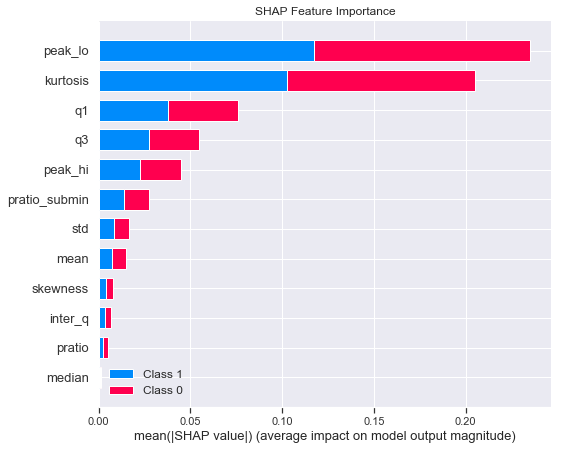

In [60]:
ml.plot_shap_importance(data, target)

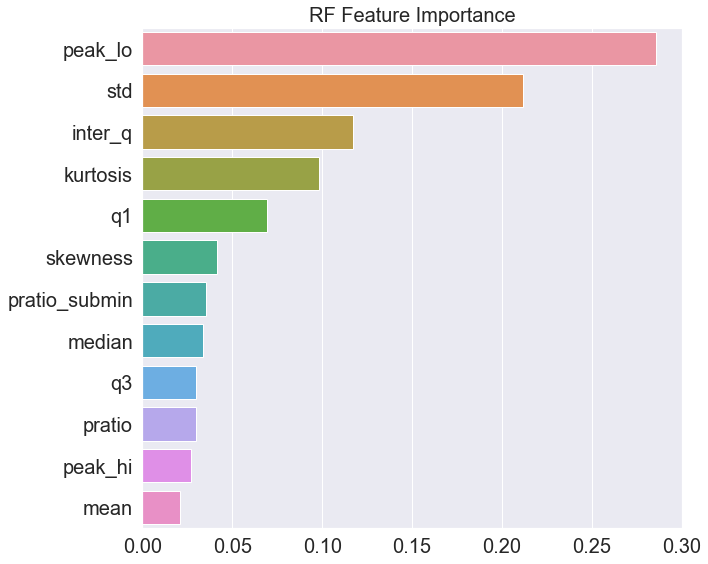

In [61]:
ml.plot_bestRF_importance(data)

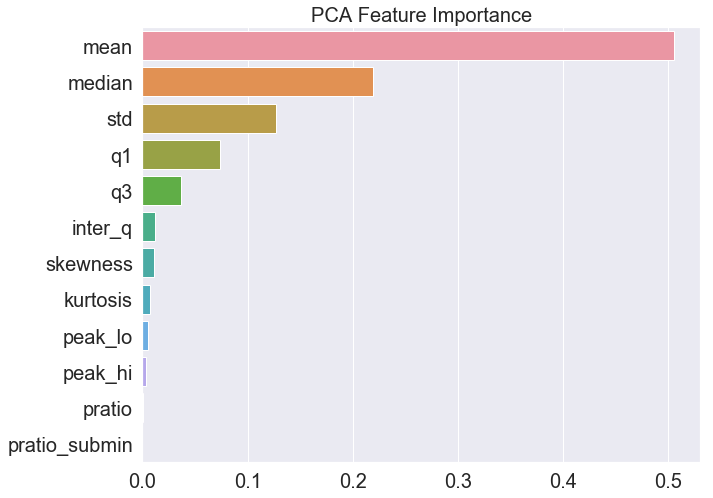

In [64]:
ml.plot_pca_importance(data, target)